In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [3]:
%cd /content/drive/MyDrive/IS403/Project/Data/

/content/drive/MyDrive/IS403/Project/Data


# Function

In [4]:
def train_test_valid(data):
  train_size = int(0.5 * len(data_amz))
  test_size = int(0.3 * len(data_amz))
  val_size = len(data_amz) - train_size - test_size

  train_data = data_amz[:train_size]
  test_data = data_amz[train_size:train_size+test_size]
  valid_data = data_amz[train_size+test_size:]

  return train_data, test_data, valid_data, train_size, test_size, val_size

In [5]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

# AMAZON

## Data

In [6]:
df_amz = pd.read_csv("AMZN.csv")
df_amz

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,58.602501,58.982498,57.599998,58.117500,58.117500,82142000
1,2017-12-04,58.692501,58.759998,56.400002,56.697498,56.697498,118638000
2,2017-12-05,56.412998,57.963501,56.237000,57.078499,57.078499,81596000
3,2017-12-06,56.899502,57.794498,56.804001,57.617500,57.617500,57066000
4,2017-12-07,57.829498,58.159500,57.549999,57.989498,57.989498,50232000
...,...,...,...,...,...,...,...
1384,2023-06-05,123.360001,125.800003,123.029999,125.300003,125.300003,47950100
1385,2023-06-06,125.070000,127.400002,125.000000,126.610001,126.610001,45695200
1386,2023-06-07,127.010002,127.370003,120.629997,121.230003,121.230003,95663300
1387,2023-06-08,123.010002,125.629997,122.260002,124.250000,124.250000,62159300


## Preprocessing

### Check null and na value

In [7]:
df_amz.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df_amz.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [9]:
print("Date column data type: ", type(df_amz['Date'][0]))
print("Open column data type: ", type(df_amz['Open'][0]))
print("Close column data type: ", type(df_amz['Close'][0]))
print("High column data type: ", type(df_amz['High'][0]))
print("Low column data type: ", type(df_amz['Low'][0]))
print("Adj Close column data type: ", type(df_amz['Adj Close'][0]))
print("Volume column data type: ", type(df_amz['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [10]:
df_amz['Date'] = pd.to_datetime(df_amz.Date)

### Choose X

In [11]:
data_amz =df_amz[['Close','Open','High','Low']]

## EDA

### Get the duration of dataset

In [12]:
print("Starting date: ",df_amz.iloc[0][0])
print("Ending date: ", df_amz.iloc[-1][0])
print("Duration: ", df_amz.iloc[-1][0]-df_amz.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

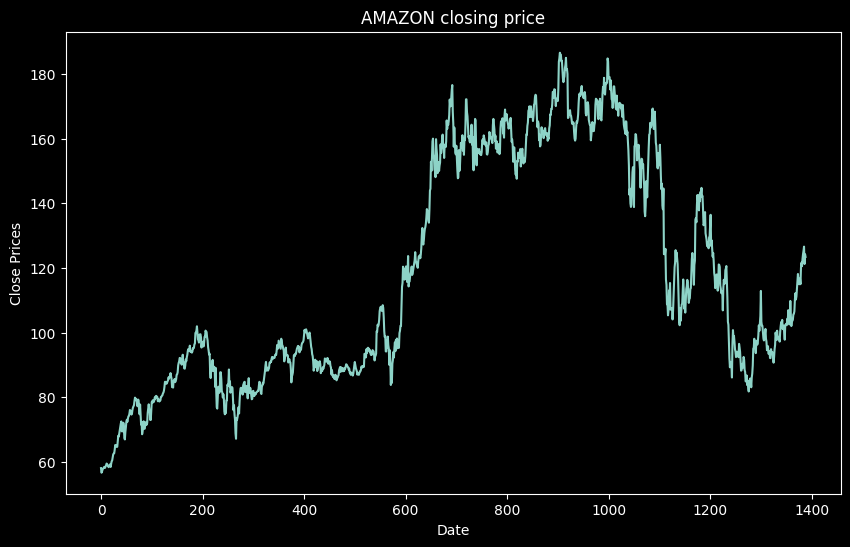

In [13]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_amz['Close'])
plt.title('AMAZON closing price')
plt.show()

## Train, test, valid

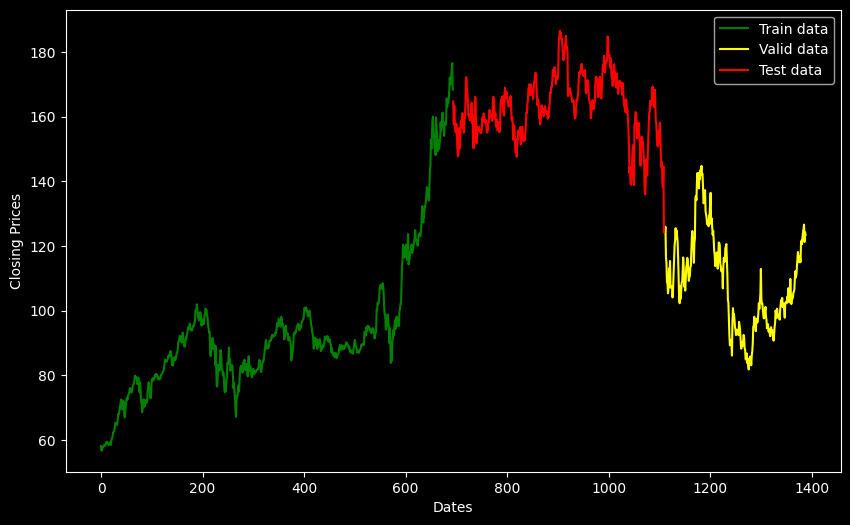

In [14]:
train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(data_amz)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['Close'], 'green', label='Train data')
plt.plot(valid_data['Close'], 'yellow', label='Valid data')
plt.plot(test_data['Close'], 'red', label='Test data')
plt.legend()

In [15]:
x_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, 0]

x_test = test_data.iloc[:, 1:]
y_test = test_data.iloc[:, 0]

x_val = valid_data.iloc[:, 1:]
y_val = valid_data.iloc[:, 0]

## Build & train model

In [16]:
model = KNeighborsRegressor()

### Choose k

In [17]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error')
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='neg_root_mean_squared_error')

In [18]:
grid.best_params_

{'n_neighbors': 2}

### Train

In [19]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=2)

## Eval

In [20]:
y_pred = knn.predict(x_test)

y_pred_val =  knn.predict(x_val)

In [21]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  1.7524626814903843
MAPE:  1.0688682100464402
RMSE:  2.480865553551175

** Validate **
MAE:  1.2631764354838715
MAPE:  1.1520326725856207
RMSE:  1.7365594870544627


## Predict

In [22]:
last_index =  data_amz.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

data = {'Open': [0] * 30,
        'High': [0] * 30,
        'Low': [0] * 30}

x_next_30_days = pd.DataFrame(data)

y_next_30_days = knn.predict(x_next_30_days)

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995]


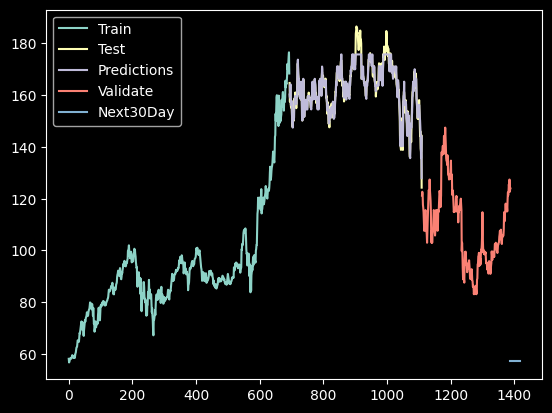

In [23]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# NVIDIA

## Data

In [24]:
df_nvda = pd.read_csv("NVDA.csv")
df_nvda

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,49.827499,50.032501,48.117500,49.419998,48.908009,81154800
1,2017-12-04,50.012501,50.075001,46.125000,46.665001,46.181549,124084400
2,2017-12-05,45.599998,48.174999,45.145000,46.935001,46.448750,98148800
3,2017-12-06,46.424999,47.535000,46.209999,47.314999,46.824821,46703200
4,2017-12-07,47.990002,48.400002,47.529999,47.997501,47.500244,54260000
...,...,...,...,...,...,...,...
1384,2023-06-05,389.089996,395.649994,387.070007,391.709991,391.669464,39609400
1385,2023-06-06,388.299988,391.600006,381.480011,386.540009,386.500000,38872900
1386,2023-06-07,389.149994,394.989990,373.559998,374.750000,374.750000,51199800
1387,2023-06-08,377.239990,388.640015,375.049988,385.100006,385.100006,41777200


## Preprocessing

### Check null and na value

In [25]:
df_nvda.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [26]:
df_nvda.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [27]:
print("Date column data type: ", type(df_nvda['Date'][0]))
print("Open column data type: ", type(df_nvda['Open'][0]))
print("Close column data type: ", type(df_nvda['Close'][0]))
print("High column data type: ", type(df_nvda['High'][0]))
print("Low column data type: ", type(df_nvda['Low'][0]))
print("Adj Close column data type: ", type(df_nvda['Adj Close'][0]))
print("Volume column data type: ", type(df_nvda['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [28]:
df_nvda['Date'] = pd.to_datetime(df_nvda.Date)

### Choose X

In [29]:
data_nvda = df_nvda[['Close','Open','High','Low']]

## EDA

### Get the duration of dataset

In [30]:
print("Starting date: ",df_nvda.iloc[0][0])
print("Ending date: ", df_nvda.iloc[-1][0])
print("Duration: ", df_nvda.iloc[-1][0]-df_nvda.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

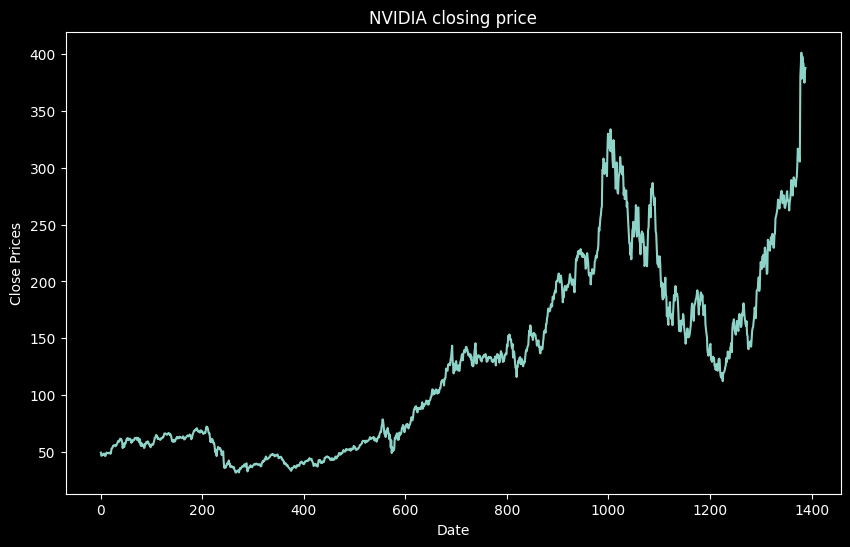

In [31]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_nvda['Close'])
plt.title('NVIDIA closing price')
plt.show()

## Train, test, valid

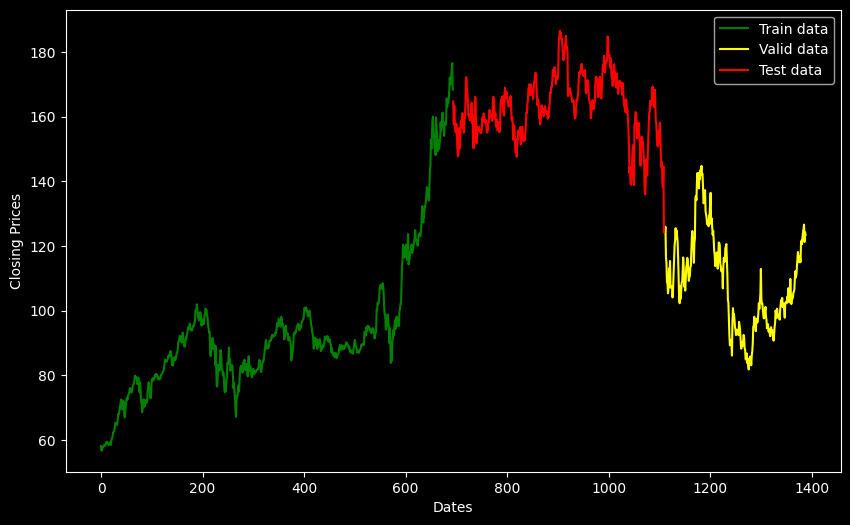

In [32]:
train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(data_nvda)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['Close'], 'green', label='Train data')
plt.plot(valid_data['Close'], 'yellow', label='Valid data')
plt.plot(test_data['Close'], 'red', label='Test data')
plt.legend()

In [33]:
x_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, 0]

x_test = test_data.iloc[:, 1:]
y_test = test_data.iloc[:, 0]

x_val = valid_data.iloc[:, 1:]
y_val = valid_data.iloc[:, 0]

## Build & train model

In [34]:
model = KNeighborsRegressor()

### Choose k

In [35]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error')
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='neg_root_mean_squared_error')

In [36]:
grid.best_params_

{'n_neighbors': 2}

### Train

In [37]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=2)

## Eval

In [38]:
y_pred = knn.predict(x_test)

y_pred_val =  knn.predict(x_val)

In [39]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  1.7524626814903843
MAPE:  1.0688682100464402
RMSE:  2.480865553551175

** Validate **
MAE:  1.2631764354838715
MAPE:  1.1520326725856207
RMSE:  1.7365594870544627


## Predict

In [40]:
last_index =  data_nvda.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

data = {'Open': [0] * 30,
        'High': [0] * 30,
        'Low': [0] * 30}

x_next_30_days = pd.DataFrame(data)

y_next_30_days = knn.predict(x_next_30_days)

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995]


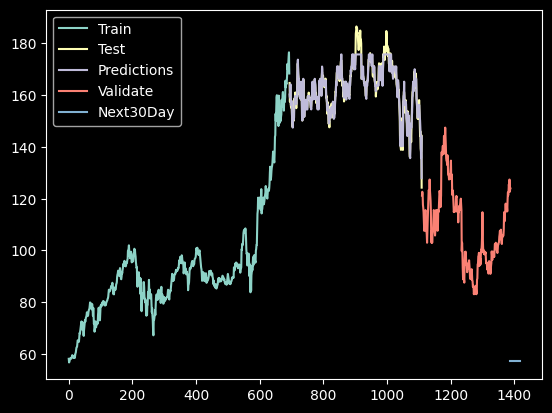

In [41]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

# TESLA

## Data

In [42]:
df_tsla = pd.read_csv("TSLA.csv")
df_tsla

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-01,20.362667,20.688000,20.336666,20.435333,20.435333,64393500
1,2017-12-04,20.433332,20.551332,20.040667,20.346666,20.346666,87526500
2,2017-12-05,20.133333,20.533333,20.066668,20.246668,20.246668,69697500
3,2017-12-06,20.006666,20.892668,20.000000,20.884001,20.884001,107929500
4,2017-12-07,20.799999,21.242001,20.736668,20.749332,20.749332,71709000
...,...,...,...,...,...,...,...
1384,2023-06-05,217.800003,221.289993,214.520004,217.610001,217.610001,151143100
1385,2023-06-06,216.139999,221.910004,212.529999,221.309998,221.309998,146911600
1386,2023-06-07,228.000000,230.830002,223.199997,224.570007,224.570007,185710800
1387,2023-06-08,224.220001,235.229996,223.009995,234.860001,234.860001,164489700


## Preprocessing

### Check null and na value

In [43]:
df_tsla.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [44]:
df_tsla.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Check datatype of each column

In [45]:
print("Date column data type: ", type(df_tsla['Date'][0]))
print("Open column data type: ", type(df_tsla['Open'][0]))
print("Close column data type: ", type(df_tsla['Close'][0]))
print("High column data type: ", type(df_tsla['High'][0]))
print("Low column data type: ", type(df_tsla['Low'][0]))
print("Adj Close column data type: ", type(df_tsla['Adj Close'][0]))
print("Volume column data type: ", type(df_tsla['Low'][0]))

Date column data type:  <class 'str'>
Open column data type:  <class 'numpy.float64'>
Close column data type:  <class 'numpy.float64'>
High column data type:  <class 'numpy.float64'>
Low column data type:  <class 'numpy.float64'>
Adj Close column data type:  <class 'numpy.float64'>
Volume column data type:  <class 'numpy.float64'>


### Convert date from string to date format

In [46]:
df_tsla['Date'] = pd.to_datetime(df_tsla.Date)

### Choose X

In [47]:
data_tsla = df_tsla[['Close','Open','High','Low']]

## EDA

### Get the duration of dataset

In [48]:
print("Starting date: ",df_tsla.iloc[0][0])
print("Ending date: ", df_tsla.iloc[-1][0])
print("Duration: ", df_tsla.iloc[-1][0]-df_tsla.iloc[0][0])

Starting date:  2017-12-01 00:00:00
Ending date:  2023-06-09 00:00:00
Duration:  2016 days 00:00:00


### Visualize the per day closing price of the stock

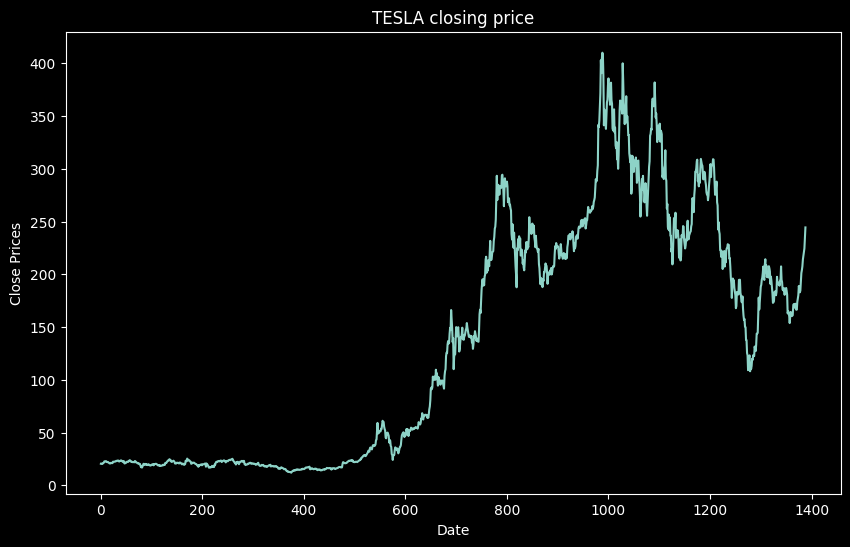

In [49]:
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(df_tsla['Close'])
plt.title('TESLA closing price')
plt.show()

## Train, test, valid

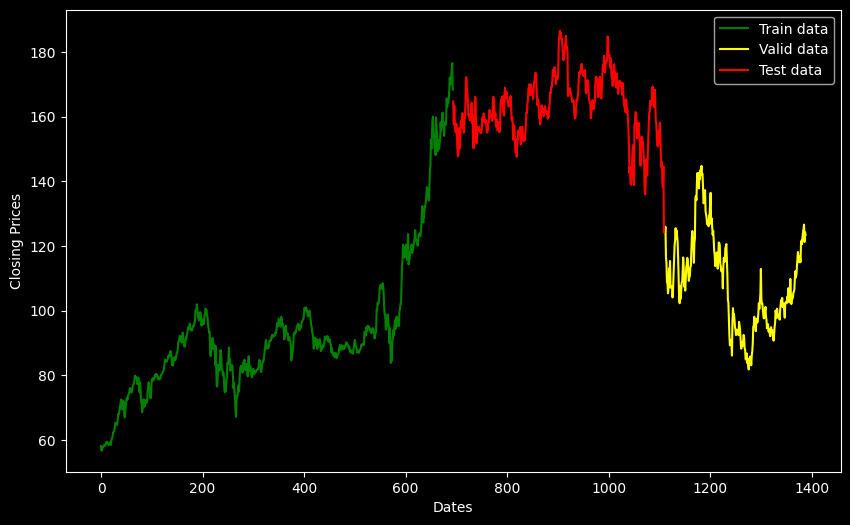

In [50]:
train_data, test_data, valid_data, train_size, test_size, val_size = train_test_valid(data_tsla)

plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data['Close'], 'green', label='Train data')
plt.plot(valid_data['Close'], 'yellow', label='Valid data')
plt.plot(test_data['Close'], 'red', label='Test data')
plt.legend()

In [51]:
x_train = train_data.iloc[:, 1:]
y_train = train_data.iloc[:, 0]

x_test = test_data.iloc[:, 1:]
y_test = test_data.iloc[:, 0]

x_val = valid_data.iloc[:, 1:]
y_val = valid_data.iloc[:, 0]

## Build & train model

In [52]:
model = KNeighborsRegressor()

### Choose k

In [53]:
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(model, param_grid, cv=10, scoring='neg_root_mean_squared_error')
grid.fit(x_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='neg_root_mean_squared_error')

In [54]:
grid.best_params_

{'n_neighbors': 2}

### Train

In [55]:
knn = KNeighborsRegressor(n_neighbors=2)
knn.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=2)

## Eval

In [56]:
y_pred = knn.predict(x_test)

y_pred_val =  knn.predict(x_val)

In [57]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  1.7524626814903843
MAPE:  1.0688682100464402
RMSE:  2.480865553551175

** Validate **
MAE:  1.2631764354838715
MAPE:  1.1520326725856207
RMSE:  1.7365594870544627


## Predict

In [58]:
last_index =  data_tsla.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

data = {'Open': [0] * 30,
        'High': [0] * 30,
        'Low': [0] * 30}

x_next_30_days = pd.DataFrame(data)

y_next_30_days = knn.predict(x_next_30_days)

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995
 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995 57.3479995]


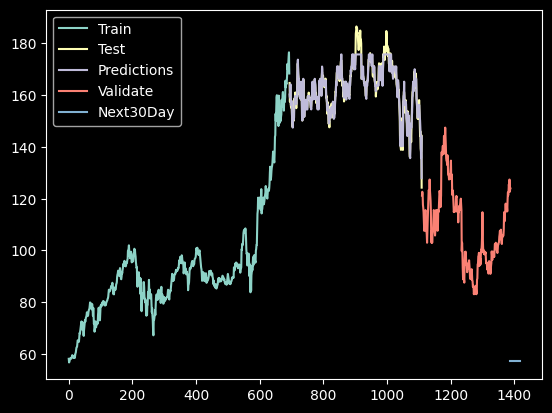

In [59]:
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(valid_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()